### Problem Description:
InsureNow is a leading commercial Insurance provider with PAN India presence, The
company wants to build a prediction algorithm based on a subset of data from 2002 to
2009.

### Data Description:
The dataset has 12 columns across 3 datasets:

### Evaluation Metric: Recall

### Disposition - Target Variable - States if the Claim has been Approved, Settled or Denied

# Import the libraries

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Read The Dataset

In [3]:
df_claim=pd.read_csv("/home/datasets/lab/MiTH/Insurance_Claim_Info_data.csv")
df_date=pd.read_csv("/home/datasets/lab/MiTH/Insurance_Date_data.csv")
df_result=pd.read_csv("/home/datasets/lab/MiTH/Insurance_Result_data.csv")
df_test=pd.read_excel("/home/datasets/lab/MiTH/test_data.xlsx")

### Number of rows and columns

In [4]:
print(df_claim.shape)
print(df_date.shape)
print(df_result.shape)
print(df_test.shape)

(34110, 7)
(34110, 3)
(34110, 4)
(3791, 9)


In [5]:
df_claim.columns

Index(['Claim Number', 'City Code', 'City', 'Enterprise Type', 'Claim Type',
       'Claim Site', 'Product Insured'],
      dtype='object')

### Merge the data

In [6]:
df_merge = pd.merge(df_claim, df_result, on="Claim Number")

In [7]:
df_final = pd.merge(df_merge, df_date, on="Claim Number")

### Number of rows and columns of merged data 

In [8]:
df_final.shape

(34110, 12)

In [9]:
df_final.head()

,Claim Number,City Code,City,Enterprise Type,Claim Type,Claim Site,Product Insured,Claim Amount,Close Amount,Disposition,Incident Date,Date Received
0,DQW1NZO0PL,NSK,Nashik,Public Limited Company,Property Loss,In Transit,Inventory - Raw Material,490.00,0.00,Deny,25-05-2007,06-07-2007
1,JS5GAPRN5B,BOM,Mumbai,One Person Company,Property Loss,In Transit,Cameras and other Misc. Security Equipment,300.00,150.00,Settle,17-09-2006,27-09-2006
2,ZTSVAQSEAQ,LKO,Lucknow,Public Limited Company,Property Loss,In Transit,Fixtures,83.98,83.98,Approve in Full,12-06-2006,17-07-2006
3,EW7NWHI7LI,DEL,Delhi,Sole Proprietorship,Property Loss,In Transit,Pumps and Motors,507.88,0.00,Deny,13-11-2005,05-12-2005
4,UJOFDC41EL,DEL,Delhi,One Person Company,Property Loss,In Transit,Misc. Engineering Tools,83.46,41.73,Settle,28-07-2008,12-08-2008


In [10]:
df_final.columns

Index(['Claim Number', 'City Code', 'City', 'Enterprise Type', 'Claim Type',
       'Claim Site', 'Product Insured', 'Claim Amount', 'Close Amount',
       'Disposition', 'Incident Date', 'Date Received'],
      dtype='object')

In [11]:
df_test.columns

Index(['Claim Number', 'Incident Date', 'Date Received', 'City Code', 'City',
       'Enterprise Type', 'Claim Type', 'Claim Site', 'Product Insured'],
      dtype='object')

### Understand the dataset

In [12]:
df_final.dtypes

Claim Number        object
City Code           object
City                object
Enterprise Type     object
Claim Type          object
Claim Site          object
Product Insured     object
Claim Amount       float64
Close Amount       float64
Disposition         object
Incident Date       object
Date Received       object
dtype: object

### Finding the unique levels

In [13]:
df_final.nunique()

Claim Number       34110
City Code             23
City                  23
Enterprise Type       13
Claim Type             2
Claim Site             3
Product Insured       13
Claim Amount       11944
Close Amount        6509
Disposition            3
Incident Date       2685
Date Received       1832
dtype: int64

#### Dropping Claim Number & City Code

In [14]:
df_final.drop(['Claim Number','City Code'], axis=1, inplace=True)

In [15]:
df_final.dtypes

City                object
Enterprise Type     object
Claim Type          object
Claim Site          object
Product Insured     object
Claim Amount       float64
Close Amount       float64
Disposition         object
Incident Date       object
Date Received       object
dtype: object

### Summary of the dataset

In [16]:
df_final.describe(include='all')

,City,Enterprise Type,Claim Type,Claim Site,Product Insured,Claim Amount,Close Amount,Disposition,Incident Date,Date Received
count,34110,34110,34110,34110,34110,34110.000000,34110.000000,34110,34110,34110
unique,23,13,2,3,13,NaN,NaN,3,2685,1832
top,Mumbai,Sole Proprietorship,Property Loss,In Transit,Inventory - Raw Material,NaN,NaN,Deny,19-04-2004,21-04-2004
freq,2562,6259,21216,28806,8110,NaN,NaN,17848,38,215
mean,NaN,NaN,NaN,NaN,NaN,717.844178,104.883016,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,8290.881802,1393.564677,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,60.000000,0.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,175.000000,0.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,460.000000,75.000000,NaN,NaN,NaN


### Missing Data

In [17]:
df_final.isnull().sum()

City               0
Enterprise Type    0
Claim Type         0
Claim Site         0
Product Insured    0
Claim Amount       0
Close Amount       0
Disposition        0
Incident Date      0
Date Received      0
dtype: int64

#### Observation: There are no missing values in the dataset

### Check for duplicate rows.

In [18]:
print(f"There are {df_final.duplicated().sum()} duplicate rows in the data set.")

There are 10 duplicate rows in the data set.


### Remove duplicate rows.

In [19]:
df_final=df_final.drop_duplicates()
print("The duplicate rows are removed.")

The duplicate rows are removed.


In [20]:
df_final.shape

(34100, 10)

In [21]:
df_final.dtypes

City                object
Enterprise Type     object
Claim Type          object
Claim Site          object
Product Insured     object
Claim Amount       float64
Close Amount       float64
Disposition         object
Incident Date       object
Date Received       object
dtype: object

### Store categorical and numerical attribute name

In [22]:
num_attr = ['Claim Amount','Close Amount']
cat_attr = ['City','Enterprise Type','Claim Type', 'Claim Site', 'Product Insured','Disposition','Incident Date','Date Received']

### Convert all attribute to appropriate type

In [23]:
df_final[cat_attr] = df_final[cat_attr].astype('category')

In [24]:
df_final.dtypes

City               category
Enterprise Type    category
Claim Type         category
Claim Site         category
Product Insured    category
Claim Amount        float64
Close Amount        float64
Disposition        category
Incident Date      category
Date Received      category
dtype: object

### Q1. What is the average % of claims received when the claim is 'Settled' ?

In [25]:
Avg_claims=df_final.groupby(by=["Disposition"])['Claim Amount'].mean()

In [26]:
Avg_claims

Disposition
Approve in Full     149.722611
Deny               1081.964086
Settle              530.574472
Name: Claim Amount, dtype: float64

### Observation: Average % of claims received when the claim is 'Settled'- 530.574472

### Feature Engineering

### Conversion into date format

In [27]:
df_final['Incident Date']=pd.to_datetime(df_final['Incident Date'])
df_final['Date Received']=pd.to_datetime(df_final['Date Received'])

In [28]:
df_final.dtypes

City                     category
Enterprise Type          category
Claim Type               category
Claim Site               category
Product Insured          category
Claim Amount              float64
Close Amount              float64
Disposition              category
Incident Date      datetime64[ns]
Date Received      datetime64[ns]
dtype: object

### Creating new column Reporting delay

In [29]:
df_final['Reporting delay'] = (df_final['Date Received'] - df_final['Incident Date']).dt.days

In [30]:
df_final.head()

,City,Enterprise Type,Claim Type,Claim Site,Product Insured,Claim Amount,Close Amount,Disposition,Incident Date,Date Received,Reporting delay
0,Nashik,Public Limited Company,Property Loss,In Transit,Inventory - Raw Material,490.00,0.00,Deny,2007-05-25,2007-06-07,13
1,Mumbai,One Person Company,Property Loss,In Transit,Cameras and other Misc. Security Equipment,300.00,150.00,Settle,2006-09-17,2006-09-27,10
2,Lucknow,Public Limited Company,Property Loss,In Transit,Fixtures,83.98,83.98,Approve in Full,2006-12-06,2006-07-17,-142
3,Delhi,Sole Proprietorship,Property Loss,In Transit,Pumps and Motors,507.88,0.00,Deny,2005-11-13,2005-05-12,-185
4,Delhi,One Person Company,Property Loss,In Transit,Misc. Engineering Tools,83.46,41.73,Settle,2008-07-28,2008-12-08,133


#### Observation: There are some date differences which are in negative which is not possible. It means there are some incorrect entries in the dataset.

In [31]:
df_final.drop(['Incident Date', 'Date Received'], inplace=True,axis=1)

In [32]:
df_final.head()

,City,Enterprise Type,Claim Type,Claim Site,Product Insured,Claim Amount,Close Amount,Disposition,Reporting delay
0,Nashik,Public Limited Company,Property Loss,In Transit,Inventory - Raw Material,490.00,0.00,Deny,13
1,Mumbai,One Person Company,Property Loss,In Transit,Cameras and other Misc. Security Equipment,300.00,150.00,Settle,10
2,Lucknow,Public Limited Company,Property Loss,In Transit,Fixtures,83.98,83.98,Approve in Full,-142
3,Delhi,Sole Proprietorship,Property Loss,In Transit,Pumps and Motors,507.88,0.00,Deny,-185
4,Delhi,One Person Company,Property Loss,In Transit,Misc. Engineering Tools,83.46,41.73,Settle,133


#### Distribution of Reporting delay column

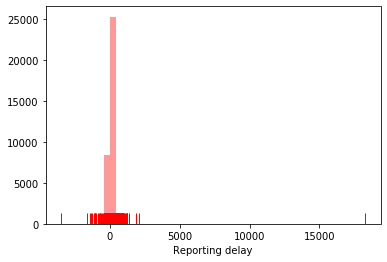

In [33]:
ax = sns.distplot(df_final['Reporting delay'],rug=True,kde=False,color='red')

### Q2. Which 'Product' has the highest delay in Reporting (In days) ?

In [34]:
sorted_df = df_final.sort_values(by='Reporting delay',ascending=False)
print(sorted_df)

             City            Enterprise Type       Claim Type  Claim Site  \
20637  Coimbatore      Joint-Venture Company  Property Damage  In Transit   
22085        Pune      Joint-Venture Company    Property Loss   Warehouse   
15848       Patna         One Person Company  Property Damage  In Transit   
24448      Nagpur        Sole Proprietorship  Property Damage  In Transit   
9445     Amritsar         One Person Company  Property Damage  In Transit   
...           ...                        ...              ...         ...   
7401    Bangalore         One Person Company    Property Loss  In Transit   
17862       Thane  Private Ltd. MSME - Small    Property Loss  In Transit   
30929      Nagpur         One Person Company    Property Loss   Warehouse   
18116   Bangalore     Public Limited Company    Property Loss  In Transit   
32956   Hyderabad        Sole Proprietorship  Property Damage  In Transit   

                                         Product Insured  Claim Amount  \
2

In [35]:
sorted_df.head(10)

,City,Enterprise Type,Claim Type,Claim Site,Product Insured,Claim Amount,Close Amount,Disposition,Reporting delay
20637,Coimbatore,Joint-Venture Company,Property Damage,In Transit,Inventory - Raw Material,96.58,0.00,Deny,18279
22085,Pune,Joint-Venture Company,Property Loss,Warehouse,"Heating, ventilation, and air conditioning (HV...",1950.00,0.00,Deny,2118
15848,Patna,One Person Company,Property Damage,In Transit,Inventory - Raw Material,83.98,0.00,Deny,1839
24448,Nagpur,Sole Proprietorship,Property Damage,In Transit,Misc. Electronic Items,103.95,0.00,Deny,1396
9445,Amritsar,One Person Company,Property Damage,In Transit,Inventory - Finished Goods,13.78,0.00,Deny,1248
23326,Vadodara,Foreign Subsidary,Property Loss,In Transit,"Heating, ventilation, and air conditioning (HV...",540.00,0.00,Deny,1213
763,Ahmedabad,One Person Company,Property Loss,Warehouse,Misc. Lab Equipment,100.00,0.00,Deny,1201
6352,Coimbatore,Joint-Venture Company,Property Damage,Warehouse,Misc. Engineering Tools,172.00,0.00,Deny,1172
27737,Visakhapatnam,Partnership Firm,Property Damage,Warehouse,Furniture,3450.00,0.00,Deny,1126
1334,Bhopal,Private Limited Company,Property Loss,Warehouse,Inventory - Finished Goods,10.55,10.55,Approve in Full,1055


#### Observation: 'Inventory-Raw material' has the highest delay in Reporting in the city Coimbatore.

#### Univariate Analysis on Categorical Columns

### 4. Which City has reported the highest number of incidents ?

In [36]:
def barplot(column,df):
    bar_plot1 = sns.countplot(x=column, data=df)
    
    total = len(df[column])
    for p in bar_plot1.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        height = p.get_height()
        bar_plot1.text(p.get_x()+ p.get_width()/2, height + 30, percentage, ha="center")

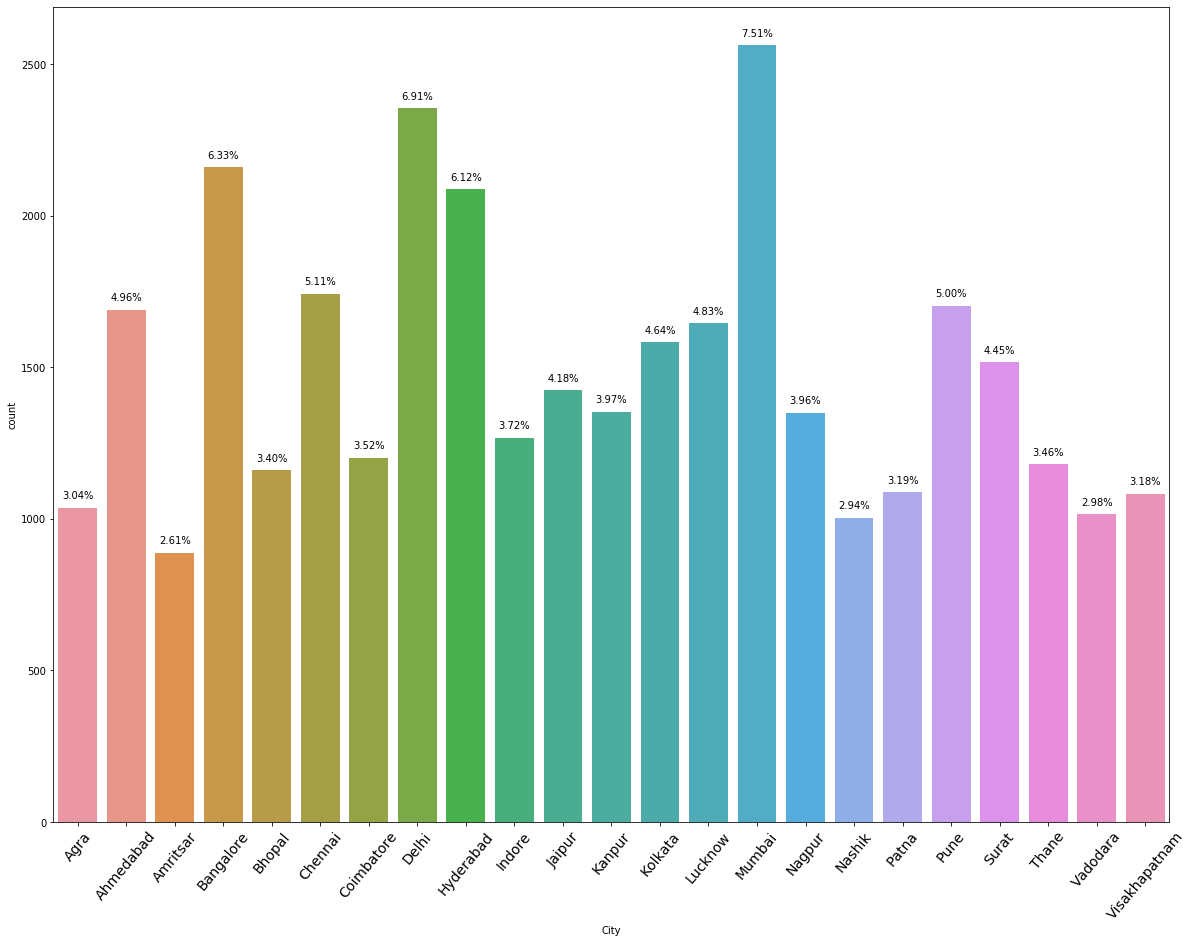

In [37]:
plt.figure(figsize=(20, 15))
plt.xticks(fontsize=14, rotation=50)
barplot("City",df_final)

#### Observation: Mumbai has reported the highest number of incidents 

### 5. Which Type of Claims have the highest number of incidents ?

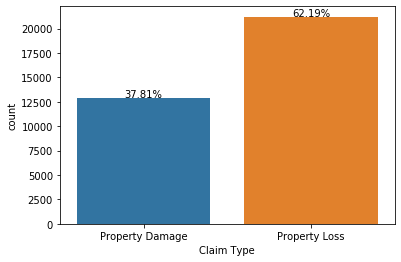

In [38]:
barplot("Claim Type",df_final)

### Observation: Property loss claim type has highest number of incidents 

### 6. Which Enterprise Type has reported the highest number of incidents ?

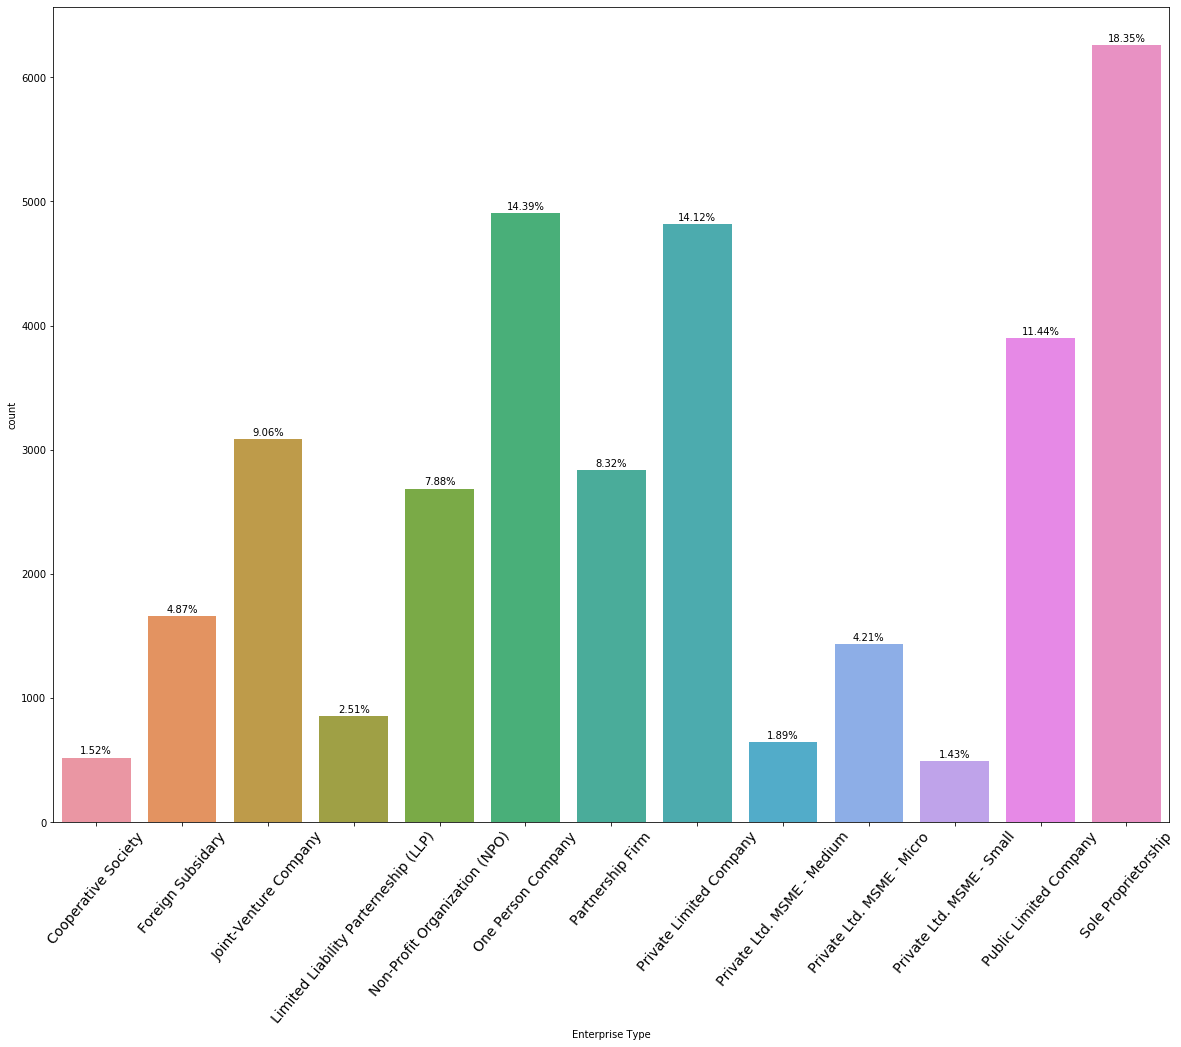

In [39]:
plt.figure(figsize=(20, 15))
plt.xticks(fontsize=14, rotation=50)
barplot("Enterprise Type",df_final)

### Observation: Sole Proprietorship Enterprise type has the highest number of incidents

# Bi-variate Analysis

# Boxplot for Numeric Vs Categorical attributes

#### Q3 How claim type and filed Claim Amount could affect the settlement of claim amount?

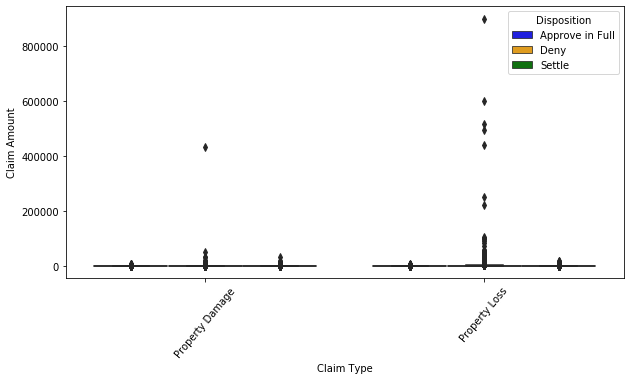

In [40]:
plt.figure(figsize=(10, 5))
plt.xticks(fontsize=10, rotation=50)
sns.boxplot(x="Claim Type", y="Claim Amount", data=df_final, hue='Disposition',palette=['blue','orange','green'])

In [41]:
df_final.dtypes

City               category
Enterprise Type    category
Claim Type         category
Claim Site         category
Product Insured    category
Claim Amount        float64
Close Amount        float64
Disposition        category
Reporting delay       int64
dtype: object

In [42]:
### Percentage of Claim Received
df_final['Percentage_Received'] = (df_final['Close Amount']/df_final['Claim Amount'])*100

In [43]:
df_final.head(10)

,City,Enterprise Type,Claim Type,Claim Site,Product Insured,Claim Amount,Close Amount,Disposition,Reporting delay,Percentage_Received
0,Nashik,Public Limited Company,Property Loss,In Transit,Inventory - Raw Material,490.00,0.00,Deny,13,0.000000
1,Mumbai,One Person Company,Property Loss,In Transit,Cameras and other Misc. Security Equipment,300.00,150.00,Settle,10,50.000000
2,Lucknow,Public Limited Company,Property Loss,In Transit,Fixtures,83.98,83.98,Approve in Full,-142,100.000000
3,Delhi,Sole Proprietorship,Property Loss,In Transit,Pumps and Motors,507.88,0.00,Deny,-185,0.000000
4,Delhi,One Person Company,Property Loss,In Transit,Misc. Engineering Tools,83.46,41.73,Settle,133,50.000000
5,Chennai,Private Limited Company,Property Loss,In Transit,Misc. Engineering Tools,52.49,52.49,Approve in Full,56,100.000000
6,Vadodara,Joint-Venture Company,Property Damage,In Transit,Inventory - Raw Material,24.50,0.00,Deny,49,0.000000
7,Amritsar,Partnership Firm,Property Damage,In Transit,Misc. Electronic Items,372.27,313.14,Settle,-133,84.116367
8,Bangalore,Private Limited Company,Property Loss,In Transit,Fixtures,150.00,0.00,Deny,2,0.000000
9,Ahmedabad,Foreign Subsidary,Property Damage,In Transit,Misc. Electronic Items,500.00,50.00,Settle,54,10.000000


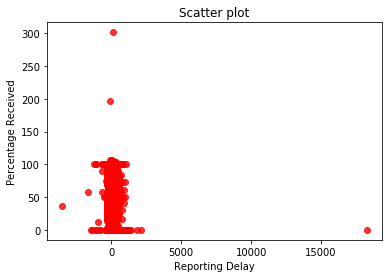

In [44]:
plt.scatter(df_final['Reporting delay'], df_final['Percentage_Received'], c='red', alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('Reporting Delay')
plt.ylabel('Percentage Received')
plt.show()

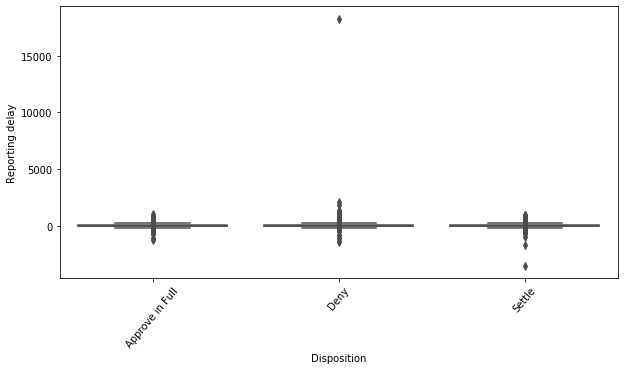

In [45]:
plt.figure(figsize=(10, 5))
plt.xticks(fontsize=10, rotation=50)
sns.boxplot(x="Disposition", y="Reporting delay", data=df_final,palette=['blue','orange'])

### Check Data types of test data

In [46]:
df_test=pd.read_excel("/home/datasets/lab/MiTH/test_data.xlsx")

In [47]:
df_test.dtypes

Claim Number       object
Incident Date      object
Date Received      object
City Code          object
City               object
Enterprise Type    object
Claim Type         object
Claim Site         object
Product Insured    object
dtype: object

In [48]:
df_test.drop(['Claim Number', 'City Code'], inplace=True,axis=1)

In [49]:
df_test.dtypes

Incident Date      object
Date Received      object
City               object
Enterprise Type    object
Claim Type         object
Claim Site         object
Product Insured    object
dtype: object

In [50]:
cat_attr_test = ['City','Enterprise Type','Claim Type', 'Claim Site', 'Product Insured','Incident Date','Date Received']

In [51]:
df_test[cat_attr_test] = df_test[cat_attr_test].astype('category')

In [52]:
df_test.dtypes

Incident Date      category
Date Received      category
City               category
Enterprise Type    category
Claim Type         category
Claim Site         category
Product Insured    category
dtype: object

In [53]:
df_test['Incident Date']=pd.to_datetime(df_test['Incident Date'])
df_test['Date Received']=pd.to_datetime(df_test['Date Received'])

In [54]:
df_test.dtypes

Incident Date      datetime64[ns]
Date Received      datetime64[ns]
City                     category
Enterprise Type          category
Claim Type               category
Claim Site               category
Product Insured          category
dtype: object

In [55]:
df_test['Reporting delay'] = (df_test['Date Received'] - df_test['Incident Date']).dt.days

In [56]:
df_test.head()

,Incident Date,Date Received,City,Enterprise Type,Claim Type,Claim Site,Product Insured,Reporting delay
0,2006-09-21,2006-12-26,Pune,One Person Company,Property Loss,In Transit,Inventory - Finished Goods,96
1,2009-01-15,2009-11-02,Pune,Limited Liability Parterneship (LLP),Property Loss,In Transit,Fixtures,291
2,2005-08-17,2005-01-09,Ahmedabad,Private Limited Company,Property Loss,Warehouse,Inventory - Raw Material,-220
3,2005-02-15,2005-01-06,Delhi,One Person Company,Property Damage,In Transit,Inventory - Finished Goods,-40
4,2003-03-17,2003-01-04,Pune,Private Limited Company,Property Damage,In Transit,Misc. Electronic Items,-72


#### Observation: There are some date differences which are in negative in the test data which is not possible. It means there are some incorrect entries in the test data.

In [57]:
df_test.drop(['Incident Date', 'Date Received'], inplace=True,axis=1)

In [58]:
df_test.head(3)

,City,Enterprise Type,Claim Type,Claim Site,Product Insured,Reporting delay
0,Pune,One Person Company,Property Loss,In Transit,Inventory - Finished Goods,96
1,Pune,Limited Liability Parterneship (LLP),Property Loss,In Transit,Fixtures,291
2,Ahmedabad,Private Limited Company,Property Loss,Warehouse,Inventory - Raw Material,-220


In [59]:
df_test.isnull().sum()

City               0
Enterprise Type    0
Claim Type         0
Claim Site         0
Product Insured    0
Reporting delay    0
dtype: int64

#### Observation: There are no null values in the test set

In [60]:
df_test.nunique()

City                23
Enterprise Type     13
Claim Type           2
Claim Site           3
Product Insured     13
Reporting delay    628
dtype: int64

#### Distribution of dependent variable

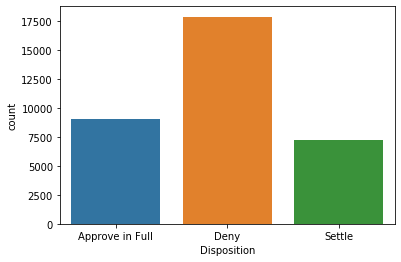

Deny               52.322581
Approve in Full    26.536657
Settle             21.140762
Name: Disposition, dtype: float64

In [61]:
sns.countplot(x="Disposition", data=df_final)
plt.show()
df_final.Disposition.value_counts(normalize=True)*100

## Divide the data into train and test

In [62]:
#Splitting the data
y=df_final["Disposition"]
X=df_final.drop('Disposition', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,stratify=y,random_state=123)  

In [63]:
print(y_train.value_counts(normalize=True)*100)
print("\n")
print(y_test.value_counts(normalize=True)*100)

Deny               52.324047
Approve in Full    26.535924
Settle             21.140029
Name: Disposition, dtype: float64


Deny               52.316716
Approve in Full    26.539589
Settle             21.143695
Name: Disposition, dtype: float64


### LabelEncoder : Target Attributes

In [64]:
y_train.value_counts()

Deny               14274
Approve in Full     7239
Settle              5767
Name: Disposition, dtype: int64

In [65]:
le = LabelEncoder()

le.fit(y_train)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [66]:
print(le.classes_)
print(le.inverse_transform([0, 1, 2]))

['Approve in Full' 'Deny' 'Settle']
['Approve in Full' 'Deny' 'Settle']


In [67]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2]), array([ 7239, 14274,  5767]))

In [68]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2]), array([1810, 3568, 1442]))

# Converting Categorical attributes to Numeric attributes

In [69]:
X_train.columns

Index(['City', 'Enterprise Type', 'Claim Type', 'Claim Site',
       'Product Insured', 'Claim Amount', 'Close Amount', 'Reporting delay',
       'Percentage_Received'],
      dtype='object')

In [70]:
X_train.drop(['Claim Amount', 'Close Amount','Percentage_Received','Reporting delay'], inplace=True,axis=1)

In [71]:
X_test.drop(['Claim Amount', 'Close Amount','Percentage_Received','Reporting delay'], inplace=True,axis=1)

In [72]:
X_train.head()

,City,Enterprise Type,Claim Type,Claim Site,Product Insured
8142,Kanpur,One Person Company,Property Damage,In Transit,Inventory - Raw Material
13854,Mumbai,Private Ltd. MSME - Micro,Property Loss,In Transit,"Heating, ventilation, and air conditioning (HV..."
19490,Delhi,One Person Company,Property Damage,Warehouse,Misc. Electronic Items
10523,Lucknow,Private Limited Company,Property Loss,In Transit,Inventory - Finished Goods
18701,Bangalore,Public Limited Company,Property Loss,In Transit,Misc. Electrical Equipment


In [73]:
X_test.head()

,City,Enterprise Type,Claim Type,Claim Site,Product Insured
3635,Mumbai,Public Limited Company,Property Loss,In Transit,Misc. Engineering Tools
9323,Mumbai,One Person Company,Property Loss,In Transit,Inventory - Finished Goods
14757,Agra,Sole Proprietorship,Property Loss,Warehouse,Pumps and Motors
32282,Ahmedabad,Private Ltd. MSME - Micro,Property Damage,In Transit,Misc. Electronic Items
32758,Coimbatore,Joint-Venture Company,Property Damage,In Transit,Misc. Engineering Tools


In [74]:
cat_attr = X_train.select_dtypes(include=['category']).columns
cat_attr

Index(['City', 'Enterprise Type', 'Claim Type', 'Claim Site',
       'Product Insured'],
      dtype='object')

### Using OneHotEncoder, converting Categorical attributes to Numeric attributes

In [75]:
enc = OneHotEncoder(drop = 'first')

enc.fit(X_train[cat_attr])

OneHotEncoder(drop='first')

In [76]:
X_train_ohe=enc.transform(X_train[cat_attr]).toarray()
X_test_ohe=enc.transform(X_test[cat_attr]).toarray()
df_X_test_ohe=enc.transform(df_test[cat_attr]).toarray()

# Model Building

# Decision Trees

In [77]:
clf_dt = DecisionTreeClassifier(max_depth=5)

In [78]:
clf_dt.fit(X_train_ohe,y_train)

DecisionTreeClassifier(max_depth=5)

In [79]:
y_pred_train = clf_dt.predict(X_train_ohe)
y_pred_test = clf_dt.predict(X_test_ohe)

## Function for Classification Report

In [80]:
def classifcation_report_train_test(y_train, y_train_pred, y_test, y_test_pred):

    print('''
            =========================================
               CLASSIFICATION REPORT FOR TRAIN DATA
            =========================================
            ''')
    print(classification_report(y_train, y_train_pred, digits=4))

    print('''
            =========================================
               CLASSIFICATION REPORT FOR TEST DATA
            =========================================
            ''')
    print(classification_report(y_test, y_test_pred, digits=4))

# Function to calculate accuracy, recall, precision and F1 score

In [81]:
scores = pd.DataFrame(columns=['Model', 'Train_Accuracy', 'Train_Recall', 'Train_Precision', 'Train_F1_Score', 
                               'Test_Accuracy', 'Test_Recall', 'Test_Precision', 'Test_F1_Score'])

def get_metrics(train_actual, train_predicted, test_actual, test_predicted, model_description, dataframe):

    train_accuracy  = accuracy_score(train_actual, train_predicted)
    train_recall    = recall_score(train_actual, train_predicted, average="weighted")
    train_precision = precision_score(train_actual, train_predicted, average="weighted")
    train_f1score   = f1_score(train_actual, train_predicted, average="weighted")
    
    test_accuracy   = accuracy_score(test_actual, test_predicted)
    test_recall     = recall_score(test_actual, test_predicted, average="weighted")
    test_precision  = precision_score(test_actual, test_predicted, average="weighted")
    test_f1score    = f1_score(test_actual, test_predicted, average="weighted")

    dataframe       = dataframe.append(pd.Series([model_description, 
                                                  train_accuracy, train_recall, train_precision, train_f1score,
                                                  test_accuracy, test_recall, test_precision, test_f1score],
                                                 index=scores.columns ), 
                                       ignore_index=True)

    return(dataframe)

In [82]:
scores = get_metrics(y_train, y_pred_train, y_test, y_pred_test, "DecisionTrees", scores)
scores

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,DecisionTrees,0.547434,0.547434,0.63684,0.453001,0.547067,0.547067,0.424708,0.453322


In [83]:
classifcation_report_train_test(y_train, y_pred_train, y_test, y_pred_test)


               CLASSIFICATION REPORT FOR TRAIN DATA
            
              precision    recall  f1-score   support

           0     0.5131    0.2651    0.3496      7239
           1     0.5529    0.9117    0.6883     14274
           2     1.0000    0.0002    0.0003      5767

    accuracy                         0.5474     27280
   macro avg     0.6887    0.3923    0.3461     27280
weighted avg     0.6368    0.5474    0.4530     27280


               CLASSIFICATION REPORT FOR TEST DATA
            
              precision    recall  f1-score   support

           0     0.5099    0.2691    0.3523      1810
           1     0.5531    0.9092    0.6878      3568
           2     0.0000    0.0000    0.0000      1442

    accuracy                         0.5471      6820
   macro avg     0.3544    0.3928    0.3467      6820
weighted avg     0.4247    0.5471    0.4533      6820



#### GridSearch CV

In [137]:
clf_dt_gs = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'], 
              'max_depth': [3,4,5],
              'min_samples_split': [5,10],
              'min_samples_leaf': [2]}

from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(clf_dt_gs, parameters, cv=5, scoring='recall', verbose=50, n_jobs=-1, refit=True)

In [139]:
gs.fit(X_train_ohe, y_train )

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [3, 4, 5], 'min_samples_leaf': [2],
                         'min_samples_split': [5, 10]},
             scoring='recall', verbose=50)

In [140]:
gs.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 5}

In [141]:
train_pred_dt = gs.predict(X_train_ohe)
test_pred_dt = gs.predict(X_test_ohe)

In [142]:
def evaluate_model(act, pred):
    print("Confusion Matrix \n", confusion_matrix(act, pred))
    print("Accuracy : ", accuracy_score(act, pred))
    print("Recall   : ", recall_score(act, pred,average="weighted"))
    print("Precision: ", precision_score(act, pred,average="weighted"))
    print("F1_score : ", f1_score(act, pred,average="weighted"))

In [143]:
print("--Train--")
evaluate_model(y_train, train_pred_dt)

--Train--
Confusion Matrix 
 [[ 1918  5321     0]
 [ 1588 12686     0]
 [  445  5322     0]]
Accuracy :  0.5353372434017595
Recall   :  0.5353372434017595
Precision:  0.41334898186218105
F1_score :  0.444014579424073


In [144]:
print("--Test--")
evaluate_model(y_test, test_pred_dt)

--Test--
Confusion Matrix 
 [[ 461 1349    0]
 [ 428 3140    0]
 [ 112 1330    0]]
Accuracy :  0.5280058651026392
Recall   :  0.5280058651026392
Precision:  0.40453235681048905
F1_score :  0.4370533311615377


# Random Forests

In [84]:
clf_rf = RandomForestClassifier()

In [85]:
clf_rf.fit(X=X_train_ohe, y=y_train)

RandomForestClassifier()

In [86]:
y_pred_train1 = clf_rf.predict(X_train_ohe)
y_pred_test1 = clf_rf.predict(X_test_ohe)

In [87]:
classifcation_report_train_test(y_train, y_pred_train1, y_test, y_pred_test1)


               CLASSIFICATION REPORT FOR TRAIN DATA
            
              precision    recall  f1-score   support

           0     0.6093    0.4760    0.5345      7239
           1     0.6366    0.8588    0.7312     14274
           2     0.6161    0.2530    0.3587      5767

    accuracy                         0.6291     27280
   macro avg     0.6207    0.5293    0.5414     27280
weighted avg     0.6250    0.6291    0.6002     27280


               CLASSIFICATION REPORT FOR TEST DATA
            
              precision    recall  f1-score   support

           0     0.4255    0.3315    0.3727      1810
           1     0.5710    0.7724    0.6566      3568
           2     0.2624    0.1061    0.1511      1442

    accuracy                         0.5145      6820
   macro avg     0.4196    0.4033    0.3935      6820
weighted avg     0.4671    0.5145    0.4744      6820



In [88]:
scores = get_metrics(y_train, y_pred_train1, y_test, y_pred_test1, "RandomForest", scores)
scores

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,DecisionTrees,0.547434,0.547434,0.636840,0.453001,0.547067,0.547067,0.424708,0.453322
1,RandomForest,0.629142,0.629142,0.625009,0.600231,0.514516,0.514516,0.467128,0.474358


# AdaBoost

In [89]:
clf_adaboost =  AdaBoostClassifier()

In [90]:
clf_adaboost.fit(X_train_ohe, y_train)

AdaBoostClassifier()

In [91]:
y_pred_train2 = clf_adaboost.predict(X_train_ohe)
y_pred_test2 = clf_adaboost.predict(X_test_ohe)

In [92]:
classifcation_report_train_test(y_train, y_pred_train2, y_test, y_pred_test2)


               CLASSIFICATION REPORT FOR TRAIN DATA
            
              precision    recall  f1-score   support

           0     0.4042    0.2085    0.2751      7239
           1     0.5377    0.8846    0.6688     14274
           2     0.3492    0.0038    0.0075      5767

    accuracy                         0.5190     27280
   macro avg     0.4304    0.3656    0.3171     27280
weighted avg     0.4624    0.5190    0.4245     27280


               CLASSIFICATION REPORT FOR TEST DATA
            
              precision    recall  f1-score   support

           0     0.4027    0.2105    0.2765      1810
           1     0.5354    0.8795    0.6656      3568
           2     0.3077    0.0028    0.0055      1442

    accuracy                         0.5166      6820
   macro avg     0.4153    0.3643    0.3159      6820
weighted avg     0.4521    0.5166    0.4228      6820



In [93]:
scores = get_metrics(y_train, y_pred_train2, y_test, y_pred_test2, "Adaboost", scores)
scores

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,DecisionTrees,0.547434,0.547434,0.636840,0.453001,0.547067,0.547067,0.424708,0.453322
1,RandomForest,0.629142,0.629142,0.625009,0.600231,0.514516,0.514516,0.467128,0.474358
2,Adaboost,0.518988,0.518988,0.462428,0.424550,0.516569,0.516569,0.452051,0.422764


# Build Gradient Boosting Classifier

In [94]:
clf_gbm = GradientBoostingClassifier()

In [95]:
clf_gbm.fit(X=X_train_ohe, y=y_train)

GradientBoostingClassifier()

In [96]:
y_pred_train3 = clf_gbm.predict(X_train_ohe)
y_pred_test3 = clf_gbm.predict(X_test_ohe)

In [97]:
classifcation_report_train_test(y_train, y_pred_train3, y_test, y_pred_test3)


               CLASSIFICATION REPORT FOR TRAIN DATA
            
              precision    recall  f1-score   support

           0     0.5509    0.2685    0.3611      7239
           1     0.5539    0.9185    0.6910     14274
           2     0.5190    0.0071    0.0140      5767

    accuracy                         0.5534     27280
   macro avg     0.5412    0.3981    0.3554     27280
weighted avg     0.5457    0.5534    0.4604     27280


               CLASSIFICATION REPORT FOR TEST DATA
            
              precision    recall  f1-score   support

           0     0.5387    0.2613    0.3519      1810
           1     0.5519    0.9156    0.6887      3568
           2     0.4545    0.0069    0.0137      1442

    accuracy                         0.5499      6820
   macro avg     0.5150    0.3946    0.3514      6820
weighted avg     0.5278    0.5499    0.4566      6820



In [98]:
scores = get_metrics(y_train, y_pred_train3, y_test, y_pred_test3, "GBM", scores)
scores

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,DecisionTrees,0.547434,0.547434,0.636840,0.453001,0.547067,0.547067,0.424708,0.453322
1,RandomForest,0.629142,0.629142,0.625009,0.600231,0.514516,0.514516,0.467128,0.474358
2,Adaboost,0.518988,0.518988,0.462428,0.424550,0.516569,0.516569,0.452051,0.422764
3,GBM,0.553372,0.553372,0.545694,0.460356,0.549853,0.549853,0.527797,0.456574


# XGBOOST

In [99]:
from xgboost import XGBClassifier

In [100]:
clf_xgb = XGBClassifier()

In [101]:
clf_xgb.fit(X_train_ohe, y_train)

[18:39:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [102]:
y_pred_train4 = clf_xgb.predict(X_train_ohe)
y_pred_test4 = clf_xgb.predict(X_test_ohe)

In [103]:
scores = get_metrics(y_train, y_pred_train4, y_test, y_pred_test4, "XGBoost", scores)
scores

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,DecisionTrees,0.547434,0.547434,0.636840,0.453001,0.547067,0.547067,0.424708,0.453322
1,RandomForest,0.629142,0.629142,0.625009,0.600231,0.514516,0.514516,0.467128,0.474358
2,Adaboost,0.518988,0.518988,0.462428,0.424550,0.516569,0.516569,0.452051,0.422764
3,GBM,0.553372,0.553372,0.545694,0.460356,0.549853,0.549853,0.527797,0.456574
4,XGBoost,0.582918,0.582918,0.582120,0.520930,0.543842,0.543842,0.492097,0.473133


In [104]:
classifcation_report_train_test(y_train, y_pred_train4, y_test, y_pred_test4)


               CLASSIFICATION REPORT FOR TRAIN DATA
            
              precision    recall  f1-score   support

           0     0.5676    0.3804    0.4555      7239
           1     0.5861    0.8878    0.7060     14274
           2     0.5906    0.0825    0.1448      5767

    accuracy                         0.5829     27280
   macro avg     0.5814    0.4502    0.4355     27280
weighted avg     0.5821    0.5829    0.5209     27280


               CLASSIFICATION REPORT FOR TEST DATA
            
              precision    recall  f1-score   support

           0     0.4808    0.3188    0.3834      1810
           1     0.5644    0.8624    0.6823      3568
           2     0.3274    0.0381    0.0683      1442

    accuracy                         0.5438      6820
   macro avg     0.4575    0.4064    0.3780      6820
weighted avg     0.4921    0.5438    0.4731      6820



In [1]:
### Observation: GBM is performing better than all other models

#### Predictions on Test dataset

In [105]:
df_test.head()

,City,Enterprise Type,Claim Type,Claim Site,Product Insured,Reporting delay
0,Pune,One Person Company,Property Loss,In Transit,Inventory - Finished Goods,96
1,Pune,Limited Liability Parterneship (LLP),Property Loss,In Transit,Fixtures,291
2,Ahmedabad,Private Limited Company,Property Loss,Warehouse,Inventory - Raw Material,-220
3,Delhi,One Person Company,Property Damage,In Transit,Inventory - Finished Goods,-40
4,Pune,Private Limited Company,Property Damage,In Transit,Misc. Electronic Items,-72


#### Using XGBoost

In [106]:
final_test_pred = clf_xgb.predict(df_X_test_ohe)

In [107]:
final_test_pred

array([1, 1, 1, ..., 1, 1, 1])

In [108]:
final_test_predictions = pd.DataFrame(final_test_pred,columns=['Disposition'])

In [109]:
final_test_predictions.head()

,Disposition
0,1
1,1
2,1
3,1
4,1


In [110]:
final_test_predictions['Disposition'].value_counts(normalize=True)*100

1    79.266684
0    18.332894
2     2.400422
Name: Disposition, dtype: float64

In [111]:
final_test_predictions.replace(to_replace =[1], value ="Deny",inplace=True)

In [112]:
final_test_predictions.replace(to_replace =[0], value ="Approve in Full",inplace=True)

In [113]:
final_test_predictions.replace(to_replace =[2], value ="Settle",inplace=True)

In [114]:
final_test_predictions['Disposition'].value_counts(normalize=True)*100

Deny               79.266684
Approve in Full    18.332894
Settle              2.400422
Name: Disposition, dtype: float64

In [115]:
final_test_predictions.nunique()

Disposition    3
dtype: int64

In [116]:
final_test_predictions.to_csv('test_predictions2.csv')

#### Using GBM

In [117]:
final_test_pred_gbm = clf_gbm.predict(df_X_test_ohe)

In [118]:
final_test_pred_gbm

array([0, 1, 1, ..., 1, 1, 1])

In [119]:
final_test_predictions_gbm = pd.DataFrame(final_test_pred_gbm,columns=['Disposition'])

In [120]:
final_test_predictions_gbm.head()

,Disposition
0,0
1,1
2,1
3,1
4,1


In [121]:
final_test_predictions_gbm['Disposition'].value_counts(normalize=True)*100

1    86.336059
0    13.479293
2     0.184648
Name: Disposition, dtype: float64

In [122]:
final_test_predictions_gbm.replace(to_replace =[1], value ="Deny",inplace=True)

In [123]:
final_test_predictions_gbm.replace(to_replace =[0], value ="Approve in Full",inplace=True)

In [124]:
final_test_predictions_gbm.replace(to_replace =[2], value ="Settle",inplace=True)

In [125]:
final_test_predictions_gbm['Disposition'].value_counts(normalize=True)*100

Deny               86.336059
Approve in Full    13.479293
Settle              0.184648
Name: Disposition, dtype: float64

In [126]:
final_test_predictions_gbm.nunique()

Disposition    3
dtype: int64

In [127]:
final_test_predictions_gbm.to_csv('test_predictions3.csv')